# Predicting the functional status of public water pumps in Tanzania
This competition is hosted by [drivendata.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/), an organization who works on projects at the intersection of data science and social impact, in areas like international development, health, education, research and conservation, and public services.  
It is based on data from the Tanzanian Ministry of Water; its goal is to predict the status of public water pumps: *functional*, *needs repair*, or *working*.  

The training dataset contains the target label and 40 explanatory variables for 59,400 different pumps:  
* amount_tsh - Total static head (amount water available to waterpoint)
* date_recorded - The date the row was entered
* funder - Who funded the well
* gps_height - Altitude of the well
* installer - Organization that installed the well
* longitude - GPS coordinate
* latitude - GPS coordinate
* wpt_name - Name of the waterpoint if there is one
* num_private -
* basin - Geographic water basin
* subvillage - Geographic location
* region - Geographic location
* region_code - Geographic location (coded)
* district_code - Geographic location (coded)
* lga - Geographic location
* ward - Geographic location
* population - Population around the well
* public_meeting - True/False
* recorded_by - Group entering this row of data
* scheme_management - Who operates the waterpoint
* scheme_name - Who operates the waterpoint
* permit - If the waterpoint is permitted
* construction_year - Year the waterpoint was constructed
* extraction_type - The kind of extraction the waterpoint uses
* extraction_type_group - The kind of extraction the waterpoint uses
* extraction_type_class - The kind of extraction the waterpoint uses
* management - How the waterpoint is managed
* management_group - How the waterpoint is managed
* payment - What the water costs
* payment_type - What the water costs
* water_quality - The quality of the water
* quality_group - The quality of the water
* quantity - The quantity of water
* quantity_group - The quantity of water
* source - The source of the water
* source_type - The source of the water
* source_class - The source of the water
* waterpoint_type - The kind of waterpoint
* waterpoint_type_group - The kind of waterpoint

This notebook achieved an **accuracy of 0.8170** (versus to score of 0.8286), ranking in the **top 10%** participants.

**NOTE:** this work is done under very tight deadline, so they are many areas that I implemented quickly and that need some cleaning and additional explanations. This will come later.   

In [249]:
from datetime import datetime

import numpy as np
import pandas as pd

# visualisation
import matplotlib.pyplot as plt
#set figure size
plt.rcParams['figure.figsize'] = 15, 4
import seaborn as sns
sns.set_style('whitegrid')   

# to build specific estimators
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.impute import SimpleImputer, MissingIndicator

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score

# to display all columns of dataframe 
pd.set_option('display.max_columns', 50)

# to print all outputs in a cell instead of just the last one 
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = 'all'  # 'last_expr' to revert to default behaviour 

In [250]:
# read data files
train_predictors = pd.read_csv('./input/training_X.csv')
train_target = pd.read_csv('./input/training_y.csv')
# create dataset with both label and independent variables
train_set = pd.concat([train_target[['status_group']], train_predictors], axis=1, sort=False)

# 1 Exploratory Data Analysis
The training dataset is made of 59400 observations x  40 features. 

In [251]:
print('Dimensions of training set = {:d} observations x  {:d} features'.format(train_predictors.shape[0], train_predictors.shape[1]))
train_set.sample(3)

Dimensions of training set = 59400 observations x  40 features


,status_group,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
52620,functional,26883,10.0,2013-03-22,Miziriol,1506,Miziriol,35.621183,-3.569324,Kwa Hau,0,Internal,D/Mashariki,Arusha,24,30,Karatu,Endabash,300,True,GeoData Consultants Ltd,VWC,Endawasu,True,1994,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,seasonal,seasonal,river,river/lake,surface,communal standpipe,communal standpipe
13038,functional,13586,0.0,2011-07-22,Kkkt,0,KKKT,32.840498,-9.066658,Mkisi,0,Lake Rukwa,Nkana,Mbeya,12,6,Mbozi,Msia,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,nira/tanira,nira/tanira,handpump,vwc,user-group,pay when scheme fails,on failure,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
48778,functional needs repair,42873,0.0,2013-03-20,Mashaka,1388,Government,37.966453,-4.445122,Kwa Mashaka,0,Pangani,Msasa,Kilimanjaro,3,3,Same,Kirangare,150,True,GeoData Consultants Ltd,Water authority,Kilotweni water supply,True,2010,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe


## 1.1 Target
The target contains 3 categories. They are slightly unbalanced (category *needs repair* accounts for only 7% of all observations). But the unbalance is not important enough to warrant for a specific processing. 

In [252]:
train_set['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

## 1.2 Features

Several features have missing values: funder, installer, subvillage, public meeting, scheme_management and scheme_name, permit.  
There is apparently no missing values for numerical variables.  
The variables *id* (id of each pump) and *recorded_by* (only one distinct value) have no predictive value and can safely be ignored.  

In [253]:
summary = pd.DataFrame(np.array([train_predictors.dtypes, 
                                 train_predictors.isnull().sum(), 
                                 train_predictors.nunique()]),
                       index=['Dtype', 'NbrNullValues', 'NbrDistinctVal'],                                 
                       columns=np.array(list(train_predictors)))
display(summary)

col_to_drop = ['id', 'recorded_by', 'wpt_name', 'subvillage']

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
Dtype,int64,float64,object,object,int64,object,float64,float64,object,int64,object,object,object,int64,int64,object,object,int64,object,object,object,object,object,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
NbrNullValues,0,0,0,3635,0,3655,0,0,0,0,0,371,0,0,0,0,0,0,3334,0,3877,28166,3056,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NbrDistinctVal,59400,98,356,1897,2428,2145,57516,57517,37400,65,9,19287,21,27,20,125,2092,1049,2,1,12,2696,2,55,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6


### 1.2.1 Numerical features

The data includes **9 numerical features**. Many have a high number of 0 values, which probably corresponds to missing value.  
We examine each feature, compute the percentage of 0 value and plot the feature versus target using a categorical plot (with logarithmic transform for some features).  
Then we summarize the plan that we will apply for Features Engineering, based on the findings in the EDA phase.  
*region_code* and *district_code* are ordinal categorical features. We will process them with the other categorical variables.

In [254]:
# extract all numerical variables plus target
train_num = train_predictors.select_dtypes(include=np.number)
train_num = pd.concat([train_num, train_target], axis=1)
train_num = train_num.drop(labels='id', axis=1)

train_num.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [255]:
# function to perform eda on all numerical variables
def eda_numerical_variable(col, transform='none'):
    '''perform EDA on a colum of the initial dataset. 
    Compute and display the frequency of 0 value. 
    Plot the feature versus target using a categorical plot (use transform='log' to apply logarithmic transform).'''
    
    # create df and add column coding for 0 value
    df = train_num[['status_group',col]].copy()
    df['is_zero'] = (train_num[col] == 0)

    # frequency of 0 value
    print('NUMERICAL VARIABLE: ' + col)
    print('percentage of 0 value = {:.2f}%'.format(df[df.is_zero == True].shape[0]/train_num.shape[0]*100))
   
    if transform == 'log':
        df[col] = df[col].apply(lambda x: np.log(x))

    sns.catplot(x='status_group', y=col, data=df[df.is_zero == False], kind='box');

NUMERICAL VARIABLE: amount_tsh
percentage of 0 value = 70.10%


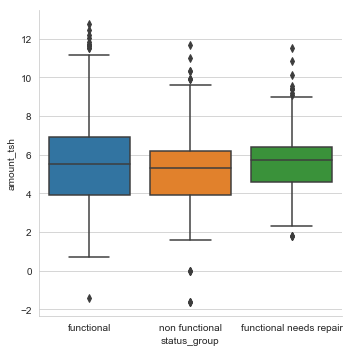

In [256]:
# amount_tsh - Total static head (amount water available to waterpoint)
eda_numerical_variable('amount_tsh', 'log')

NUMERICAL VARIABLE: gps_height
percentage of 0 value = 34.41%


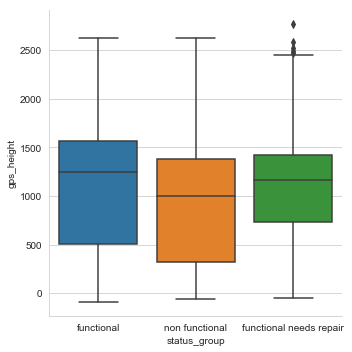

In [257]:
# gps_height - Altitude of the well
eda_numerical_variable('gps_height')

NUMERICAL VARIABLE: longitude
percentage of 0 value = 3.05%


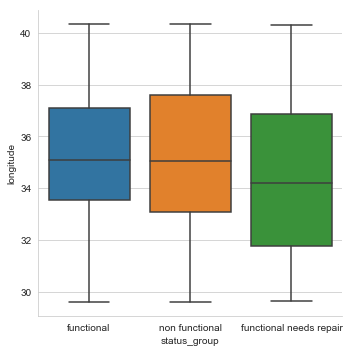

In [258]:
# longitude - GPS coordinate
eda_numerical_variable('longitude')
col_to_drop.append('longitude')

NUMERICAL VARIABLE: latitude
percentage of 0 value = 0.00%


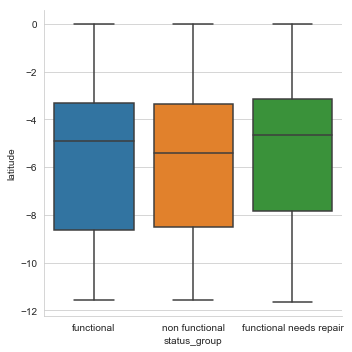

In [259]:
# latitude - GPS coordinate
eda_numerical_variable('latitude')
col_to_drop.append('latitude')

The feature **num_private** has a very high proportion of missing value (98.7%). Moreover, a separate prediction run (not shown here) with and without this feature did not show any improvement. Therefore we are not using this feature. 

NUMERICAL VARIABLE: num_private
percentage of 0 value = 98.73%


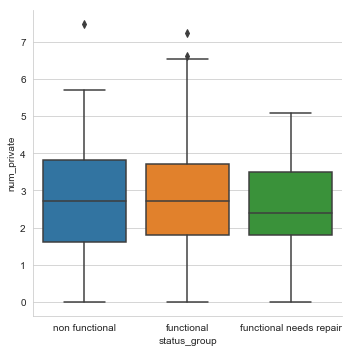

In [260]:
# num_private -
eda_numerical_variable('num_private', 'log')
col_to_drop.append('num_private')

NUMERICAL VARIABLE: population
percentage of 0 value = 35.99%


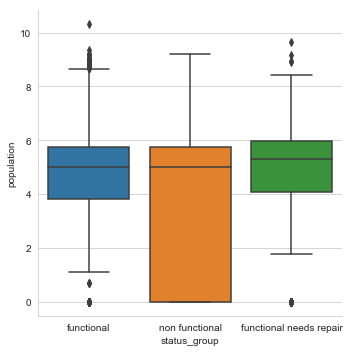

In [261]:
# population - Population around the well
eda_numerical_variable('population', 'log')

NUMERICAL VARIABLE: construction_year
percentage of 0 value = 34.86%


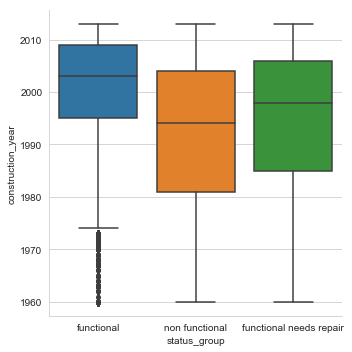

In [262]:
# construction_year - Year the waterpoint was constructed
eda_numerical_variable('construction_year')

#### 1.2.1.1 Plan for Feature Engineering of numerical features
Based on the above results, we plan Feature Engineering of numerical variables as follows:
* drop variable 'num_private'
* for the other features 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year': 
    - replace 0 with NaN
    - create a new feature coding for missing value     
    - map NaN to median

In [263]:
col_to_drop = ['num_private']
# list of numerical features with same feature engineering
col_numerical_fe1 = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year']

### 1.2.2 Categorical features

In [264]:
train_cat = train_predictors.copy()
train_cat = pd.concat([train_cat, train_target], axis=1)
train_cat.drop(labels=['longitude', 'latitude', 'num_private',
                       'amount_tsh', 'gps_height', 'population', 'construction_year',
                       'id', 'recorded_by', 'wpt_name', 'subvillage'], axis=1, inplace=True)

train_cat.sample(5)

,date_recorded,funder,installer,basin,region,region_code,district_code,lga,ward,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
54628,2011-04-12,Anglican Church,ANGLI,Wami / Ruvu,Dodoma,1,1,Mpwapwa,Chunyu,True,VWC,NaN,True,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe multiple,communal standpipe,functional
5954,2013-02-14,World Vision,World Vision,Internal,Tabora,14,1,Nzega,Miguwa,False,VWC,NaN,True,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump,functional
42877,2013-02-16,Fini Water,Fini water,Ruvuma / Southern Coast,Mtwara,99,1,Mtwara Rural,Mahurunga,True,NaN,NaN,True,nira/tanira,nira/tanira,handpump,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
4029,2011-03-20,Solidame,SOLIDAME,Rufiji,Morogoro,5,3,Kilombero,Ifakara,True,NaN,NaN,True,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,coloured,colored,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
15125,2013-01-29,World Vision,TAWASA,Lake Tanganyika,Shinyanga,17,3,Kahama,Ngongwa,True,NaN,NaN,True,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,milky,milky,seasonal,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [265]:
summary = pd.DataFrame(np.array([train_cat.dtypes, 
                                 train_cat.isnull().sum(), 
                                 train_cat.nunique()]),
                       index=['Dtype', 'NbrNullValues', 'NbrDistinctVal'],                                 
                       columns=np.array(list(train_cat)))
display(summary)

# code NaN value as 'missing' 
train_cat.fillna(value='missing_value', inplace=True)

,date_recorded,funder,installer,basin,region,region_code,district_code,lga,ward,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
Dtype,object,object,object,object,object,int64,int64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
NbrNullValues,0,3635,3655,0,0,0,0,0,0,3334,3877,28166,3056,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
NbrDistinctVal,356,1897,2145,9,21,27,20,125,2092,2,12,2696,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3


### Categorical features to transform to dummy variables
Feature **basin** seems to have high explanatory power (see for example *Ruvuma* and *Lake Rukwa* values with higher proportion of *non functional* than *functional* status). We keep it and we will map it to dummy variables.

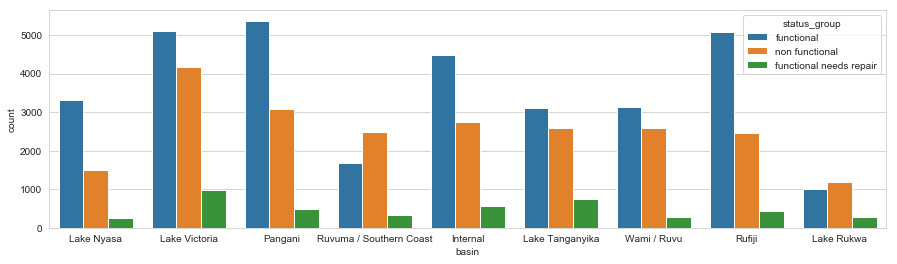

In [266]:
sns.countplot(x='basin', hue='status_group', data=train_cat);
col_categorical_onehot = ['basin']

Feature **public_meeting** is a boolean feature. It will be transformed to dummy variables after mapping NAN to *missing_value*

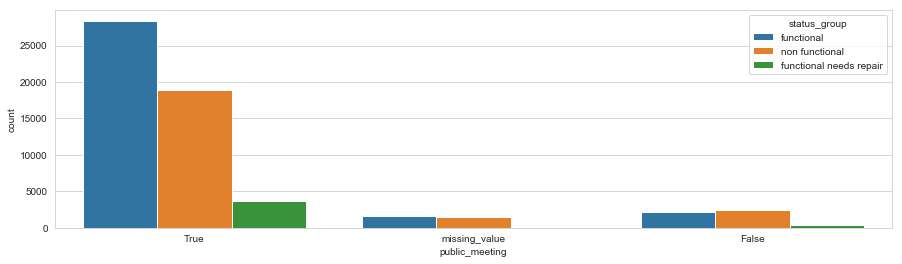

In [267]:
sns.countplot(x='public_meeting', hue='status_group', data=train_cat);
col_categorical_onehot.append('public_meeting')

Feature **scheme_management** will be mapped as dummy variables.  

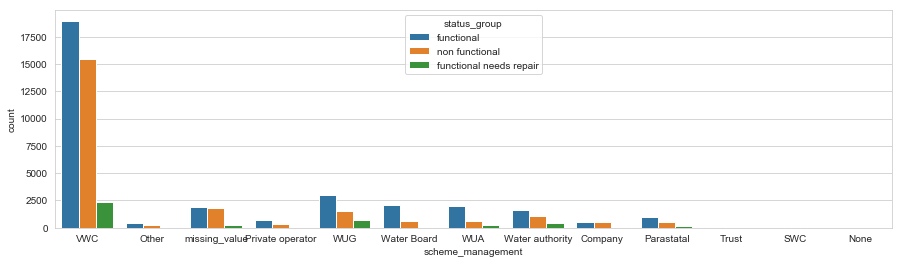

In [268]:
sns.countplot(x='scheme_management', hue='status_group', data=train_cat);
col_categorical_onehot.append('scheme_management')

Feature **permit** will be transformed to dummy variables after mapping NAN to *missing_value*

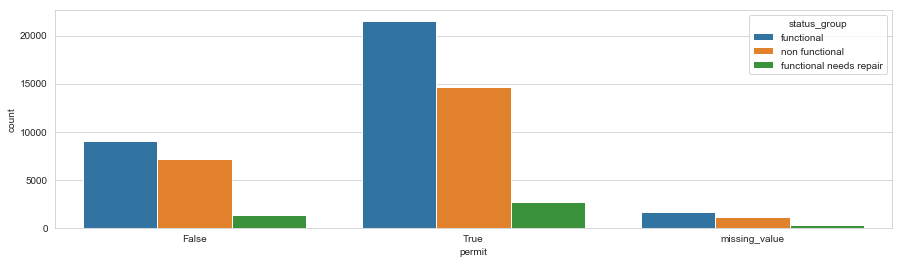

In [269]:
sns.countplot(x='permit', hue='status_group', data=train_cat);
col_categorical_onehot.append('permit')

All 3 features **extraction_type**, **extraction_type_group** and **extraction_type_class** code for similar information. The first two features contain more values but only with very low frequencies. For now, we will keep only *extraction_type_class' and map it later to dummies.  

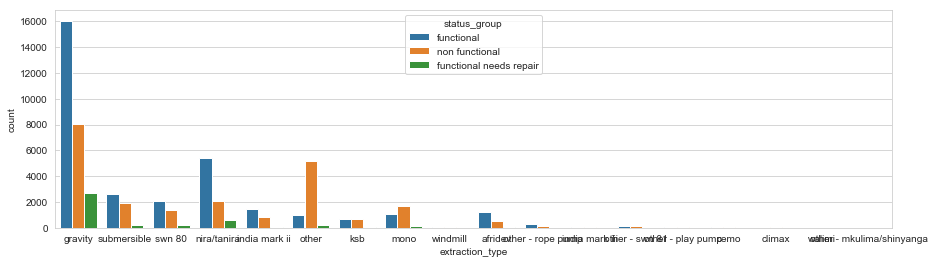

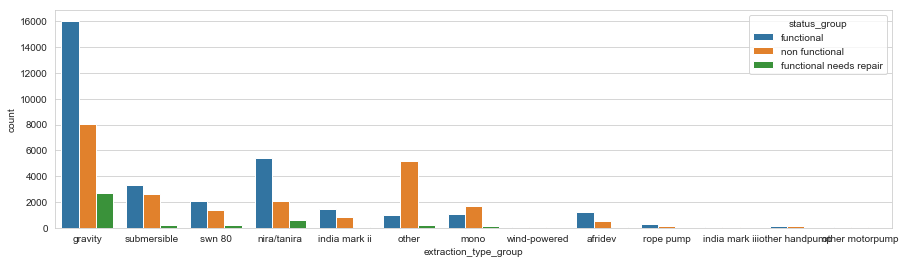

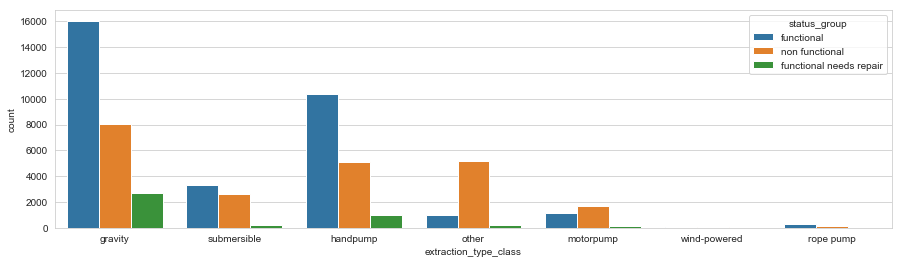

In [270]:
sns.countplot(x='extraction_type', hue='status_group', data=train_cat);
plt.show()
sns.countplot(x='extraction_type_group', hue='status_group', data=train_cat);
plt.show()
sns.countplot(x='extraction_type_class', hue='status_group', data=train_cat);
col_categorical_onehot.append('extraction_type_class')

The 2 features **management** and **management_group** do not look very informative. We drop them at least for now.  

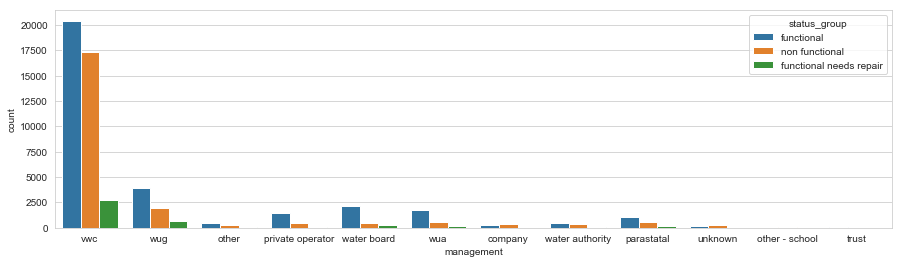

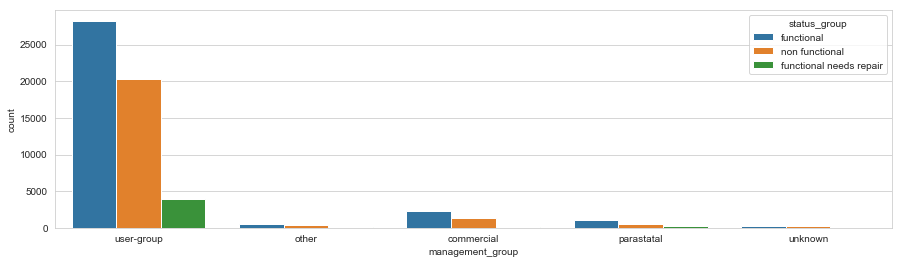

In [271]:
sns.countplot(x='management', hue='status_group', data=train_cat);
plt.show()
sns.countplot(x='management_group', hue='status_group', data=train_cat);

The 2 features **payment** and **payment_type** are identical. They definitively exhibit predictive power (see value *dry* for example ). We keep only *payment_type* and will map it to dummy variables.

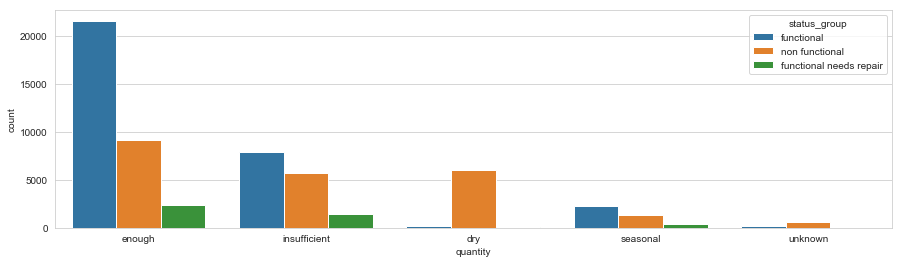

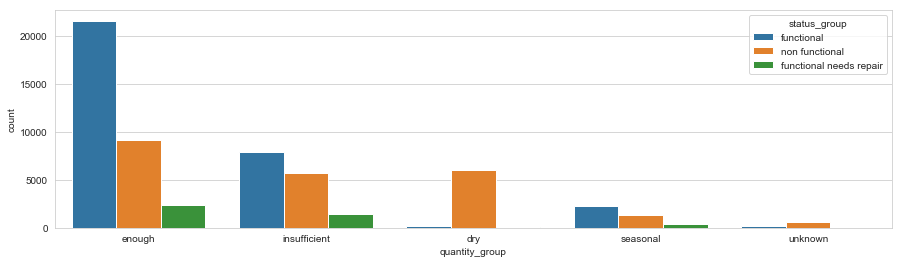

In [272]:
sns.countplot(x='quantity', hue='status_group', data=train_cat)
plt.show()
sns.countplot(x='quantity_group', hue='status_group', data=train_cat);
col_categorical_onehot.append('quantity_group')

The features **water_quality** and **quality_group** contain for similar information. Feature *water_quality* may be slightly more informative as it contains 2 additional values (*salty abandoned* and *fluoride abandoned*), but they have very low frequency. Since the addition informative power lokks negligeable, we keep only *quality_group* to reduce the number of dummy variables during FE.

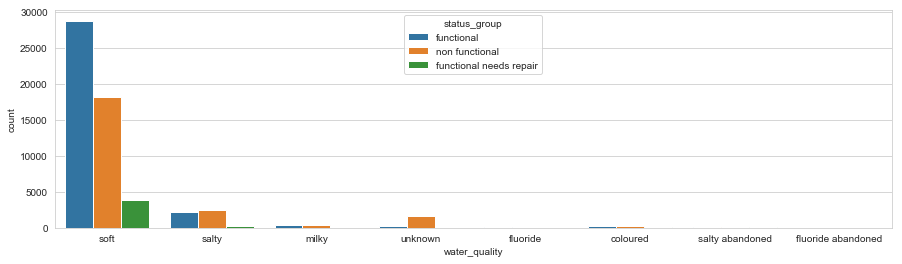

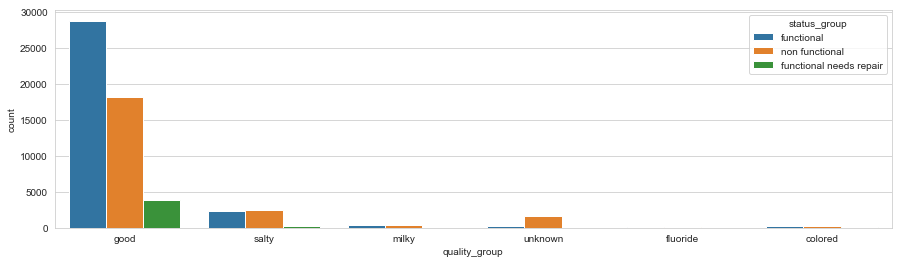

In [273]:
sns.countplot(x='water_quality', hue='status_group', data=train_cat);
plt.show()
sns.countplot(x='quality_group', hue='status_group', data=train_cat);
col_categorical_onehot.append('quality_group')

The 2 features **quantity** and **quantity_group** are identical, we keep only *quantity_group* and will transform it to dummy variables.

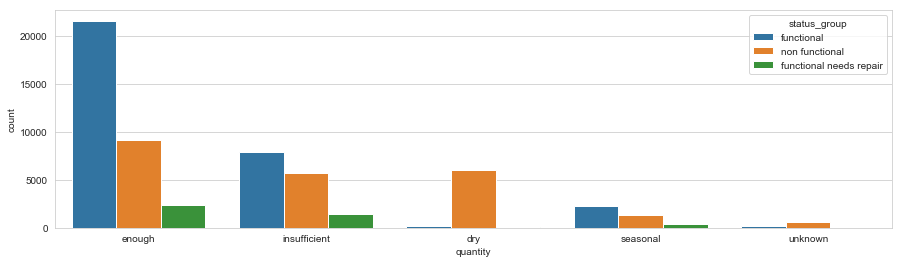

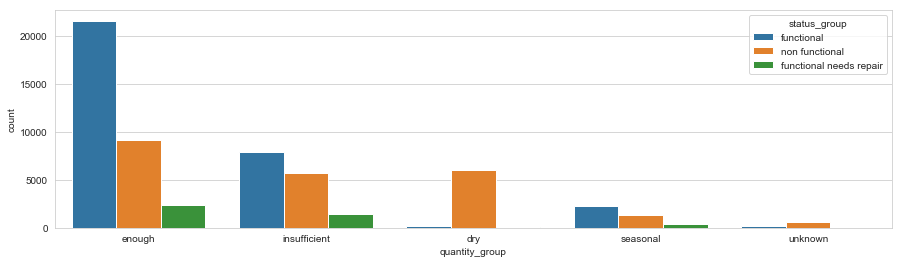

In [274]:
sns.countplot(x='quantity', hue='status_group', data=train_cat)
plt.show()
sns.countplot(x='quantity_group', hue='status_group', data=train_cat);
col_categorical_onehot.append('quantity_group')

The features **source**, **source_type**, **source_class** code for related information. Feature *source* contains slightly more information than *source_type*, so we will keep it and drop *source_type*. We will also drop *source_class* since it does not look very informative.

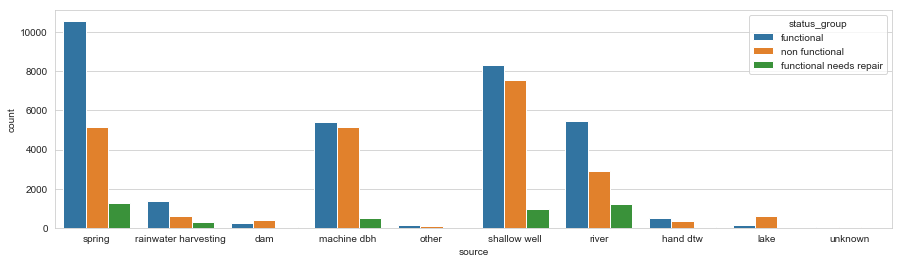

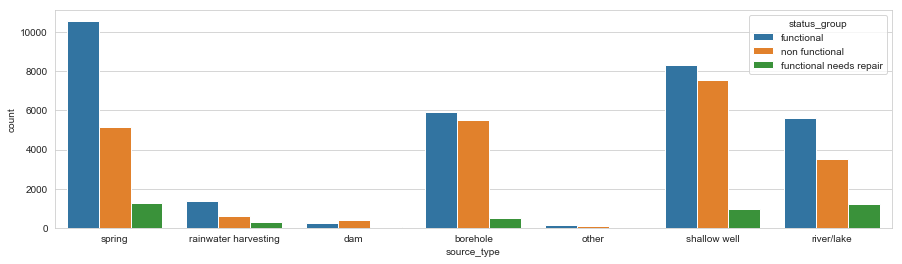

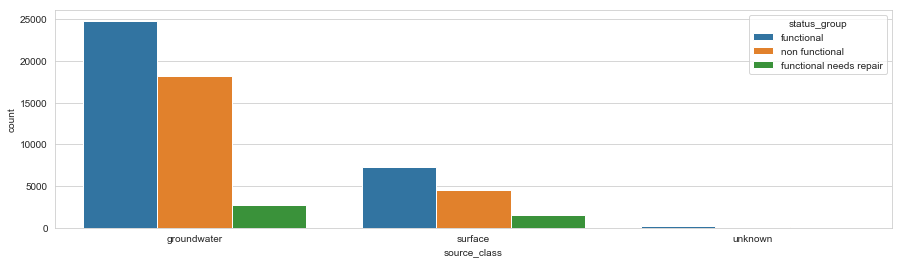

In [275]:
sns.countplot(x='source', hue='status_group', data=train_cat);
plt.show()
sns.countplot(x='source_type', hue='status_group', data=train_cat);
plt.show()
sns.countplot(x='source_class', hue='status_group', data=train_cat);
col_categorical_onehot.append('source')

The features **waterpoint_type** and **waterpoint_type_group** code for similar information, but *waterpoint_type* has one categorie more (*communal standpipe multiple*) and is more informative. We keep only feature *waterpoint_type* and will map it to dummy variables.

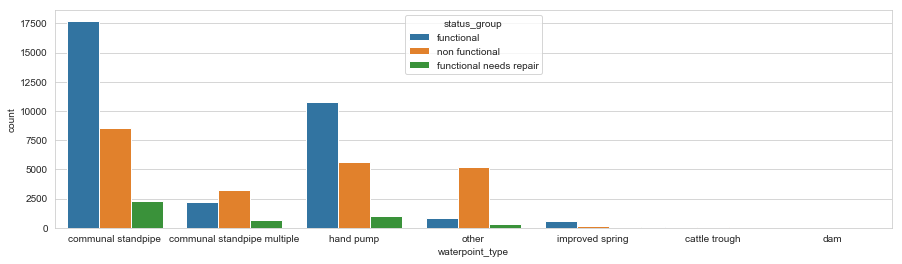

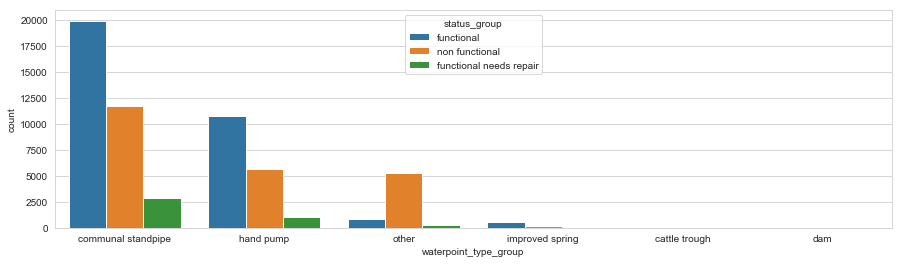

In [276]:
sns.countplot(x='waterpoint_type', hue='status_group', data=train_cat);
plt.show()
sns.countplot(x='waterpoint_type_group', hue='status_group', data=train_cat);
col_categorical_onehot.append('waterpoint_type')

### High cardinality variables
5 variables with high cardinality: 'funder', 'installer', 'lga', 'ward', 'scheme_name' (ignore this one)
will be process during FE by mapping them to a numeric function. Ignore them during EDA

In [277]:
# TODO check if we include wpt_name and subvillage 
# exclude 'wpt_name' as it significantly increases variance
col_high_cardinality = ['funder', 'installer', 'lga', 'ward', 'scheme_name']

Feature **funder**

In [278]:
df = train_predictors[['funder']].copy()
print(df.nunique())

def fe_funder(df, col):
    df[col] = df[col].str.lower()
    
    # replace funder names having typos by proper value
    df[col].replace(to_replace= 'a/co germany', value='aco/germany',  inplace=True)
    df[col].replace(to_replace= 'churc', value='church',  inplace=True)  
    df[col].replace(to_replace=['cocen', 'cocern', 'conce', 'concen'], value='concern', inplace=True) 
    df[col].replace(to_replace='compa', value='company', inplace=True)  
    df[col].replace(to_replace='commu', value='community', inplace=True)    
    df[col].replace(to_replace=['dasip', 'dasp'], value='dassip', inplace=True) 
    df[col].replace(to_replace='denish', value='danida', inplace=True)      
    df[col].replace(to_replace=['fin water', 'finn water', 'finw', 'finwater'], value='fini water', inplace=True)
    df[col].replace(to_replace='finland government', value='finland', inplace=True)       
    df[col].replace(to_replace='franc', value='france', inplace=True)   
    df[col].replace(to_replace='germany republi', value='germany', inplace=True)    
    df[col].replace(to_replace='greineker', value='greinaker', inplace=True)       
    df[col].replace(to_replace='greineker', value='greinaker', inplace=True) 
    df[col].replace(to_replace='halmashau.*', value='halmashauri', inplace=True, regex=True) # halmashau plus anything
    df[col].replace(to_replace=['hesaw', 'hesawz', 'hewasa'], value='hesawa', inplace=True) 
    df[col].replace(to_replace=['holand', 'holla'], value='holland', inplace=True)     
    df[col].replace(to_replace=['institution', 'insututional'], value='institutional', inplace=True)       
    df[col].replace(to_replace='irish government', value='irish ai', inplace=True)     
    df[col].replace(to_replace='islam', value='islamic', inplace=True) 
    df[col].replace(to_replace='italy government', value='italy', inplace=True) 
    df[col].replace(to_replace=['jaica', 'jeica', 'jika'], value='jica', inplace=True)
    df[col].replace(to_replace='korea', value='koica', inplace=True) 
    df[col].replace(to_replace=['lcdg', 'lgcd', 'lgcbg', 'lgdcg'], value='lgcdg', inplace=True) 
    df[col].replace(to_replace='lions', value='lions club', inplace=True) 
    df[col].replace(to_replace=['luthe', 'lutheran church'], value='lutheran', inplace=True)
    df[col].replace(to_replace=['milenia', 'mileniam project'], value='millenium', inplace=True)
    df[col].replace(to_replace=['missi', 'missio', 'missionaries', 'missionary'], value='mission', inplace=True)
    df[col].replace(to_replace='musilim agency', value='muslims', inplace=True) 
    df[col].replace(to_replace=['nethe', 'netherland'], value='netherlands', inplace=True)
    df[col].replace(to_replace=['ox', 'oxfarm', 'oxfam gb'], value='oxfam', inplace=True)  
    df[col].replace(to_replace='pentecosta church', value='pentecostal church', inplace=True) 
    df[col].replace(to_replace=['people from japan', 'the people of japan'], value='people of japan', inplace=True) 
    df[col].replace(to_replace=['plan int', 'plan internatio'], value='plan international', inplace=True)
    df[col].replace(to_replace='priva.*', value='private', inplace=True, regex=True) # priva plus anything
    df[col].replace(to_replace='quick.*', value='quick wings', inplace=True, regex=True) # priva plus anything
    df[col].replace(to_replace=['quik', 'quwkwin', 'qwickwin', 'qwiqwi'], value='quick wings', inplace=True)
    df[col].replace(to_replace=['rc', 'rc cathoric', 'rc ch', 'rc churc', 'rc church'], value='roman catholic', inplace=True)
    df[col].replace(to_replace=['roman', 'roman ca', 'roman cathoric', 'roman church'], value='roman catholic', inplace=True)
    df[col].replace(to_replace='redcross', value='red cross', inplace=True) 
    df[col].replace(to_replace=['rotaty club', 'lottery', 'lotary club', 'rotary i', 'lottery club'], 
                     value='rotary club', inplace=True)
    df[col].replace(to_replace=['rural water supply', 'rural water supply and sanita'], value='rural water supply and sanitat', inplace=True)
    df[col].replace(to_replace='rw.*', value='rwssp', inplace=True, regex=True) 
    df[col].replace(to_replace='schoo.*', value='school', inplace=True, regex=True) 
    df[col].replace(to_replace='secondary schoo', value='secondary', inplace=True) 
    df[col].replace(to_replace='soliderm', value='solidarm', inplace=True) 
    df[col].replace(to_replace=['sweden', 'swidish'], value='swedish', inplace=True)
    df[col].replace(to_replace='swisland.*', value='swisland', inplace=True, regex=True) 
    df[col].replace(to_replace='tot.*', value='total land care', inplace=True, regex=True) 
    df[col].replace(to_replace=['uniseg', 'uniceg', 'unice'], value='unicef', inplace=True)
    df[col].replace(to_replace='usa embassy', value='us embassy', inplace=True) 
    df[col].replace(to_replace='villa.*', value='village', inplace=True, regex=True) 
  
    # various values with unknown meaning    
    df[col].replace(to_replace=['0', 'not known', 'donor'], value='unknown', inplace=True)
    df[col].fillna(value='unknown', inplace=True)
    
    # group low frequency funders in a single category
    df_count = pd.DataFrame(df[col].value_counts())
    df_count = df_count[df_count[col] <= 3]
    low_frequency_funder = df_count.index.to_list()
    df[col].replace(to_replace=low_frequency_funder, value='low_frequency', inplace=True)    

#fe_funder(df, 'funder')
print(df.nunique())

funder    1897
dtype: int64
funder    1897
dtype: int64


Feature **installer** 

In [279]:
df = train_predictors[['installer']].copy()
print(df.nunique())

def fe_installer(df, col):
    df[col] = df[col].str.lower()
    
    # replace installer names having typos by proper value and group by installer when possible
    df[col].replace(to_replace='active tank co ltd', value='active tank co', inplace=True) 
    df[col].replace(to_replace='adra.*community', value='adra community', inplace=True, regex=True)   
    df[col].replace(to_replace='adra.*government', value='adra government', inplace=True, regex=True)
    df[col].replace(to_replace='amp contract.*', value='amp contractor', inplace=True, regex=True)
    df[col].replace(to_replace='ang.*', value='anglican', inplace=True, regex=True)    
    df[col].replace(to_replace=['aartisa', 'arisan', 'atisan'], value='artisan', inplace=True)   
    df[col].replace(to_replace='brit.*', value='british', inplace=True, regex=True)       
    df[col].replace(to_replace='building works.*', value='building works', inplace=True, regex=True)     
    df[col].replace(to_replace='care.*', value='care international', inplace=True, regex=True)     
    df[col].replace(to_replace='cartas.*', value='caritas', inplace=True, regex=True)     
    df[col].replace(to_replace=['cebtral government', 'cental government', 'centr', 'centra government', 
                                'centra govt', 'central govt', 'cetral government /rc'], 
                                value='central government', inplace=True)      
    df[col].replace(to_replace='chur', value='church', inplace=True) 
    df[col].replace(to_replace='commu.*', value='community', inplace=True, regex=True)     
    df[col].replace(to_replace='conce.*', value='concern', inplace=True, regex=True)       
    df[col].replace(to_replace='consu.*', value='consulting engineer', inplace=True, regex=True) 
    df[col].replace(to_replace='cosmo.*', value='cosmo', inplace=True, regex=True)  
    df[col].replace(to_replace='coun.*', value='council', inplace=True, regex=True)  
    df[col].replace(to_replace='district.*counci', value='district council', inplace=True, regex=True) 
    df[col].replace(to_replace='district water depar', value='district water department', inplace=True)     
    df[col].replace(to_replace='dwe.*', value='dwe', inplace=True, regex=True)  
    df[col].replace(to_replace='fin.*w.*', value='fini water', inplace=True, regex=True) 
    df[col].replace(to_replace='gold star', value='goldstar', inplace=True) 
    df[col].replace(to_replace='gove.*', value='government', inplace=True, regex=True) 
    df[col].replace(to_replace='individual', value='individuals', inplace=True) 
    df[col].replace(to_replace=['jaica', 'jaica co', 'jeica', 'jika'], value='jica', inplace=True)    
    df[col].replace(to_replace='local.*te.*', value='local technician', inplace=True, regex=True)     
    df[col].replace(to_replace='luthe.*', value='lutheran church', inplace=True, regex=True)     
    df[col].replace(to_replace='milenia.*', value='mileniam project', inplace=True, regex=True)     
    df[col].replace(to_replace='nora.*', value='norad', inplace=True, regex=True)  
    df[col].replace(to_replace='oikos.*', value='oikos africa', inplace=True, regex=True)      
    df[col].replace(to_replace=['oxfarm', 'oxfam gb'], value='oxfam', inplace=True)   
    df[col].replace(to_replace='plan*', value='plan international', inplace=True, regex=True)       
    df[col].replace(to_replace='priva', value='private', inplace=True) 
    df[col].replace(to_replace=['quwkwin', 'qwickwin'], value='quick win project', inplace=True)    
    df[col].replace(to_replace='rc*', value='rc church', inplace=True, regex=True)     
    df[col].replace(to_replace='roman*', value='roman catholic', inplace=True, regex=True)      
    df[col].replace(to_replace='rwe.*community', value='rwe community', inplace=True, regex=True)       
    df[col].replace(to_replace='save the rain usa', value='save the rain', inplace=True) 
    df[col].replace(to_replace='secondary', value='secondary school', inplace=True)     
    df[col].replace(to_replace='tanap', value='tanapa', inplace=True)       
    df[col].replace(to_replace='tanzania.*', value='tanzania government', inplace=True, regex=True)      
    df[col].replace(to_replace='tot.*land.*', value='total land care international', inplace=True, regex=True)    
    df[col].replace(to_replace='unisef', value='unicef', inplace=True)    
    df[col].replace(to_replace='vill.*', value='village', inplace=True, regex=True)      
    df[col].replace(to_replace='water.*sema', value='water aid/sema', inplace=True, regex=True)       
    df[col].replace(to_replace='wo.*bank.*', value='world bank', inplace=True, regex=True)       
    df[col].replace(to_replace='world vission', value='world vision', inplace=True)  
    
    # various values with unknown meaning    
    df[col].replace(to_replace=['0', '-0', 'not known', 'unknown installer'], value='unknown', inplace=True)
    df[col].fillna(value='unknown', inplace=True)    
    
    # group low frequency funders in a single category
    df_count = pd.DataFrame(df[col].value_counts())
    df_count = df_count[df_count[col] <= 3]
    low_frequency_funder = df_count.index.to_list()
    df[col].replace(to_replace=low_frequency_funder, value='low_frequency', inplace=True)    

#fe_installer(df, 'installer')
print(df.nunique())

df_count = pd.DataFrame(df['installer'].value_counts(dropna=False))
df_count.to_csv('./output/installer.csv', header=True, index=True)

installer    2145
dtype: int64
installer    2145
dtype: int64


In [280]:
df = train_predictors[['scheme_name']].copy()
print(df.nunique())

def fe_scheme_name(df, col):
    df[col] = df[col].str.lower()
         
    # various values with unknown meaning    
    df[col].replace(to_replace=['0', '-0', 'not known', 'unknown installer'], value='unknown', inplace=True)
    df[col].fillna(value='unknown', inplace=True)    
    
    # group low frequency funders in a single category
    df_count = pd.DataFrame(df[col].value_counts())
    df_count = df_count[df_count[col] <= 3]
    low_frequency_funder = df_count.index.to_list()
    df[col].replace(to_replace=low_frequency_funder, value='low_frequency', inplace=True)    

#fe_scheme_name(df, 'scheme_name')
print(df.nunique())

df_count = pd.DataFrame(df['scheme_name'].value_counts(dropna=False))
df_count.to_csv('./output/scheme_name.csv', header=True, index=True)



df['scheme_name'] = df['scheme_name'].str.lower()
df_count = pd.DataFrame(df['scheme_name'].value_counts(dropna=False))
df_count.to_csv('./output/scheme_name.csv', header=True, index=True)
 

print(df.nunique())

scheme_name    2696
dtype: int64
scheme_name    2696
dtype: int64
scheme_name    2576
dtype: int64


#### region and region_code
keep one of them, treat as high cardinality

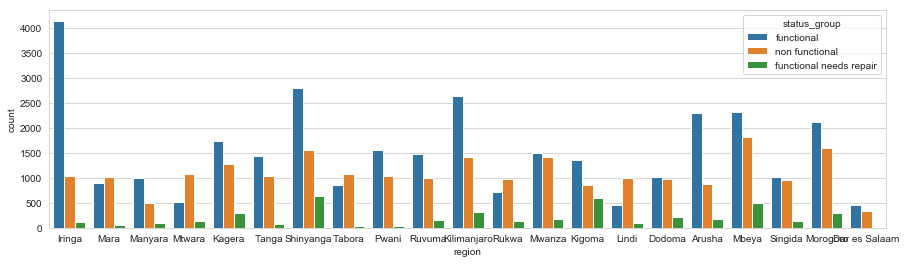

In [281]:
sns.countplot(x='region', hue='status_group', data=train_cat);
col_to_drop.append('region')
col_high_cardinality.append('region_code')

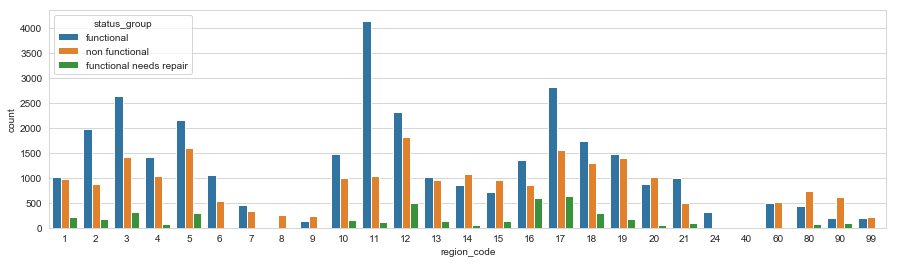

In [282]:
sns.countplot(x='region_code', hue='status_group', data=train_cat);

#### district_code
probably not very informative but process it as high cardinality

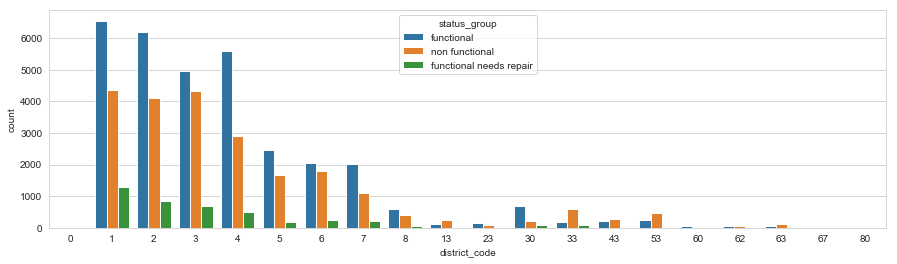

In [283]:
sns.countplot(x='district_code', hue='status_group', data=train_cat);
col_high_cardinality.append('district_code')

## Time feature

In [284]:
# extract all numerical variables plus target
ts = train_set[['date_recorded', 'status_group']]

# set the index to listing_at, order it and change its type to datetime 
ts.set_index('date_recorded', inplace=True)
ts = ts.sort_index(axis=0, ascending=True, inplace=False)
ts.index = pd.to_datetime(ts.index)

# create one dummy variable for each value of category_class (after converting it to type str)
ts = pd.get_dummies(ts.astype(str))
# show and check the result
ts.head(3)

,status_group_functional,status_group_functional needs repair,status_group_non functional
date_recorded,,,
2002-10-14,1,0,0
2004-01-07,1,0,0
2004-03-01,0,0,1


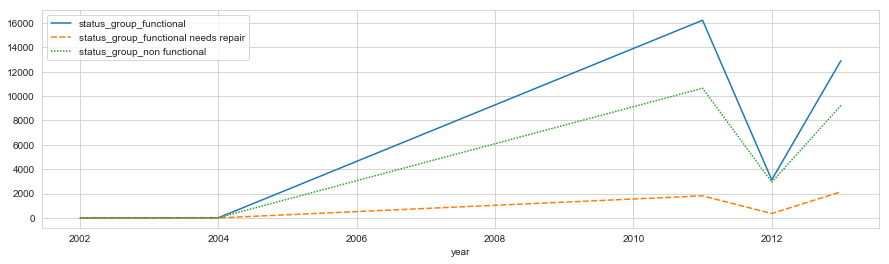

In [285]:
# extract the hour of the day to a new column
ts['year'] = ts.index.year
# aggregate each dummy variable by grouping by hour  
df_plot = ts.groupby(['year']).sum()
sns.lineplot(data=df_plot);
ts.drop('year', axis=1, inplace=True)

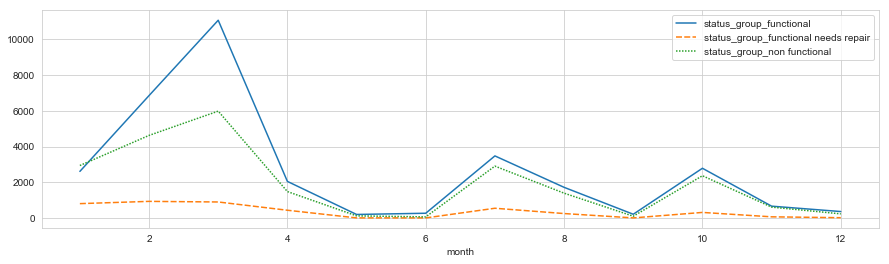

In [286]:
# extract the hour of the day to a new column
ts['month'] = ts.index.month
# aggregate each dummy variable by grouping by hour  
df_plot = ts.groupby(['month']).sum()
sns.lineplot(data=df_plot);
ts.drop('month', axis=1, inplace=True)

#### Summary
Plan for Feature Engineering of categorical variables:
* drop 'region', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_class', 'payment', 'water_quality', 'quantity', 'source_type', 'source_class', 'waterpoint_type_group'
* drop for now 'management', 'management_group'
* process as high cardinality 'funder', 'installer', 'lga', 'ward' and 'region_code', 'district_code', 'extraction_type_group'
* transform to dummy variables 'basin', 'payment_type', 'quality_group', 'quantity_group', 'source', 'waterpoint_type'
* transform to dummy variables 'public_meeting', 'permit'

# 2 Feature Engineering

In [287]:
# handle the target with mapping
train_target['status_group'] = train_target['status_group'].map({'functional': 0, 
                                                                 'functional needs repair': 1, 
                                                                 'non functional': 2})

This dataset contains several categorical variables with very high cardinality, like for example *funder* with 1897 unique values. There are 3 approaches possible to handle this type of features:
* group together values that have close meaning (this is however not possible for variables like *funder* for which there is no clear proximity measure between different values)
* discard values with low frequencies (possible, but this would probably be unsufficient to reduce enough the number of unique values)
* **transform the initial feature into a continuous numerical feature**  

We will use option 3, and we define 3 functions $f_F$, $f_R$ and $f_N$:
$$f_F(x) = \frac{N_F(x) + p_F}{N(x) + 1}$$  
$$f_R(x) = \frac{N_R(x) + p_R}{N(x) + 1}$$  
$$f_N(x) = \frac{N_N(x) + p_N}{N(x) + 1}$$ 
where:
* $x$ is a given value of the high cardinality variable V, 
* $N_F(x)$, $N_R(x)$ and $f_N(x)$ are the number of observations with V=x and respectively equal to Functional, Repair, and Non Functional 
* $N(x)$ is the total number of observations with V=X, with $N(x) = N_F(x) + N_R(x) + f_N(x)$
* $p_F$, $p_R$ and $p_N$ are the frequencies over the full set of status Functional, Repair, and Non Functional  
  
Now, it is easy to see that the sum of $f_F$, $f_R$ and $f_N$ is equal to 1 and that these 3 functions can be considered as probabilities of each status: 
$$f_F(x) + f_R(x) + f_N(x) = \frac{N_F(x) + p_F + N_R(x) + p_R + N_N(x) + p_N}{N(x) + 1}
= \frac{N_F(x) + N_R(x) + N_N(x) + p_F + p_R + p_N}{N(x) + 1} = \frac{N(x) + 1}{N(x) + 1}$$  

The rationale for these functions is:
* their value gets closer to the observed frequencies $\frac{N_F(x)}{N(x)}$ as the number of observations $N(x)$ increases. Thus they are putting more weight on frequent values 
* they have an intuitive meaning as estimation of probabilities
* they are defined even if the value x is not included in the training set  

In [288]:
# define transformer to transform high cardinality variables to numerical functions

#### TODO remove hardcoded labels

class HighCardinalityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=3):
        self._frequencies = {}
        self._label_values = []
        self._mapper = {}
        self._alpha = alpha
    
    def fit(self, X, y):
        # both X and y must be DF
        # convert y to string to have a fixed and known type  
        y_str = y.astype(str)
        
        # self._label_values = ['functional', 'functional needs repair', 'non functional']
        self._label_values = ['0', '1', '2']        
        
        # compute frequencies over full data
        self._default_frequencies = {}
        for status in self._label_values: 
            self._frequencies[status] = np.count_nonzero(y_str == status) / y_str.shape[0]  
        
        # get list of all columns in X 
        columns_to_map = list(X)
        
        self._mapper = {}
        for col in columns_to_map:
            # create df with the variable to map and the label
            df = pd.concat([X[col],y], axis=1)
            df.rename(columns={y.columns.values[0]: 'y'}, inplace=True)
            
            # replace y with 3 columns 'y_functional', 'y_functional needs repair', 'y_non functional' with counts 
            df = pd.get_dummies(data=df, columns=['y'])
            df = df.groupby(col).sum()
            
#            df['count'] = df['y_functional'] +  df['y_functional needs repair'] + df['y_non functional']
            df['count'] = df['y_0'] +  df['y_1'] + df['y_2']            
            # calculate the 3 probability estimates
# TODO handle properly removal of one column        
#            df['0'] = (df['y_0'] + self._alpha *self._frequencies['0']) / (df['count'] + self._alpha)
            df['1'] = (df['y_1'] + self._alpha * self._frequencies['1']) / (df['count'] + self._alpha)
            df['2'] = (df['y_2'] + self._alpha * self._frequencies['2']) / (df['count'] + self._alpha) 
                    
            # create mapper with format:
            #     {'col1': {'functional': {val1: f1, val2: f2, ...},
            #               'functional needs repair': {val1: f1, val2: f2, ...},
            #               'non functional': {val1: f1, val2: f2, ...}}, 
            #      'col2': ...}
#            self._mapper[col] = df[['0', '1', '2']].to_dict()
            self._mapper[col] = df[['1', '2']].to_dict()    
    
        return self
    
    def transform(self, X, y=None):
        res = X.copy()
        
        for col_name in list(X):
            for y_name in ['1', '2']:
#            for y_name in self._label_values:
                mapper = self._mapper[col_name][y_name]
                new_col = col_name + '_f_' + y_name
                res[new_col] = X[col_name].map(mapper)
                
                # fill NA value with frequency of corresponding status - TODO not tested 
                res[new_col] = res[new_col].fillna(value=self._frequencies[y_name])
             
        #drop initial columns
        res.drop(list(X), axis=1, inplace=True)
        return res
    
    def get_frequencies(self):        
        return self._frequencies
    
    def get_mapper(self):
        return self._mapper   
    
# example: transform 2 categorical values to numeric functions    
hct = HighCardinalityTransformer()
hct.fit(train_predictors[['region','lga']], train_target[['status_group']])
res = hct.transform(train_predictors[['region','lga']])
res.head(3)

HighCardinalityTransformer(alpha=None)

,region_f_1,region_f_2,lga_f_1,lga_f_2
0,0.023262,0.194667,0.019785,0.206619
1,0.030537,0.519347,0.037855,0.370171
2,0.060667,0.315985,0.016778,0.402420


### prepare data


In [289]:
def prepare_X(X):
    df = X.copy()
    
    # group similar values
    df.loc[:,'scheme_management'] = df['scheme_management'].replace(to_replace='None', value='Other')
    df.loc[:,'scheme_management'] = df['scheme_management'].replace(to_replace='missing', value='Other')
    
    # log transform of some numerical features
    df.loc[df.population > 0, 'population'] = df.loc[df.population > 0, 'population'].transform(np.log)
#    df.loc[df.amount_tsh > 0, 'amount_tsh'] = df.loc[df.amount_tsh > 0, 'amount_tsh'].transform(np.log) # does not improve accuracy with KNN
    
    # TODO - REMOVE ONCE DONE 
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['year_recorded'] = df['date_recorded'].dt.year
    df['month_recorded'] = df['date_recorded'].dt.month
    df['year_in_operation'] = df['year_recorded'] + df['month_recorded'] / 12.0 - (df['construction_year'] - 0.5)
    df.drop(labels='date_recorded', axis=1, inplace=True)

    # feature engineering for high cardinality variables
    fe_funder(df, 'funder')
    fe_installer(df, 'installer')
    fe_scheme_name(df, 'scheme_name')

    # transform boolean features to string
    for col in ['public_meeting', 'permit']:
        df.loc[:,col] = df[col].map({True: 'true', False: 'false'}, na_action='ignore')
    
    return df    
 
col_datetime = ['year_recorded', 'month_recorded', 'year_in_operation']    
X_prep = prepare_X(train_predictors)  
X_prep.head(3)

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,year_recorded,month_recorded,year_in_operation
0,69572,6000.0,roman catholic,1390,rc churchoman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,4.691348,true,GeoData Consultants Ltd,VWC,roman,false,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2011,3,12.750000
1,8776,0.0,grumeti,1399,grc churchumeti,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,5.634790,NaN,GeoData Consultants Ltd,Other,unknown,true,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2013,3,3.750000
2,34310,25.0,rotary club,686,worc churchld vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,5.521461,true,GeoData Consultants Ltd,VWC,nyumba ya mungu pipe scheme,true,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2013,2,4.666667


In [290]:
# implement pipeline

class DataFrameSelector(BaseEstimator, TransformerMixin):
    '''returns a NumPy array corresponding to the attributes in the list given as argument for the constructor'''
    def __init__(self, attribute_names):
        self._attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self._attribute_names] #.values
    
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(col_numerical_fe1)),
    ('imputer1', SimpleImputer(missing_values=0, fill_value=np.nan, copy=False)),
#    ('indicator', MissingIndicator(features='missing-only')),  # TODO doesnot work - add_indicator not available before 0.21.3
    ('imputer2', SimpleImputer(strategy='mean', copy=False)), #, add_indicator=True)),
    ('scaler', StandardScaler()),
    ])    

# pipeline for boolean/categorical features encoded with OneHot
cat_pipeline_1 = Pipeline([
    ('selector', DataFrameSelector(col_categorical_onehot)),
    ('imputer1', SimpleImputer(strategy='constant', fill_value='missing_values', copy=False)),    
    ('encoder', OneHotEncoder(sparse=False, handle_unknown='error')),   # drop=None
#    ('indicator', MissingIndicator()),  # TODO doesnot work - add_indicator not available before 0.21.3  
    ('imputer2', SimpleImputer(strategy='median', copy=False)), #, add_indicator=True)),
    ('scaler', StandardScaler()),
    ]) 

# pipeline for high cardinality categorical features
cat_hc_pipeline = Pipeline([
    ('selector', DataFrameSelector(col_high_cardinality)),
    ('high_cardinality', HighCardinalityTransformer()),
#    ('indicator', MissingIndicator()),  # TODO doesnot work - add_indicator not available before 0.21.3
    ('imputer2', SimpleImputer(strategy='mean', copy=False)), #, add_indicator=True)),  # proxy for the frequencies over the full dattaset
    ('scaler', StandardScaler()),
    ]) 

# pipeline for time features
date_pipeline = Pipeline([
    ('selector', DataFrameSelector(col_datetime)),
#    ('indicator', MissingIndicator()),  # TODO doesnot work - add_indicator not available before 0.21.3
    ('imputer', SimpleImputer(strategy='most_frequent')), #, add_indicator=True)),  # proxy for the frequencies over the full dattaset
    ('scaler', StandardScaler()),
    ]) 

full_pipeline = FeatureUnion([
    ('num1', num_pipeline),
    ('cat1', cat_pipeline_1),  
    ('hc', cat_hc_pipeline),
    ('date', date_pipeline),    
    ])

In [291]:
print('Pipeline - Numerical features included: {}'.format(col_numerical_fe1))
print('Pipeline - Categorical features engineered to dummies: {}'.format(col_categorical_onehot))
print('Pipeline - Categorical features engineered as High Cardinality: {}'.format(col_high_cardinality))
print('Pipeline - DateTime features included: {}'.format(col_datetime))

X_prep = full_pipeline.fit_transform(X_prep, train_target[['status_group']])
print(X_prep.shape)

# get train and test set 
X_train, X_test, y_train, y_test = train_test_split(X_prep, train_target[['status_group']], test_size=0.20, random_state=42)

Pipeline - Numerical features included: ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population', 'construction_year']
Pipeline - Categorical features engineered to dummies: ['basin', 'public_meeting', 'scheme_management', 'permit', 'extraction_type_class', 'quantity_group', 'quality_group', 'quantity_group', 'source', 'waterpoint_type']
Pipeline - Categorical features engineered as High Cardinality: ['funder', 'installer', 'lga', 'ward', 'scheme_name', 'region_code', 'district_code']
Pipeline - DateTime features included: ['year_recorded', 'month_recorded', 'year_in_operation']
(59400, 90)


# 3 Train models with optimization of hyperparameters
The purpose here is to run several classification models with no or limited optimization to identy a few promising models. We will optimize hyperparameters for these models in a second step.

## 3.1 K Nearest Neighbours

In [292]:
#knn = KNeighborsClassifier(n_neighbors=7, p=1)
#knn.fit(X_train, y_train['status_group']) 
#y_pred = knn.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#print('accuracy = {:.4f}'.format(accuracy))

## 3.2 Random Forest Classifier

In [293]:
#parameters = {'n_estimators':[100,200,300], 'min_samples_split':[6,8,10], 'max_features':[4,6,8]}
parameters = {'max_depth':[20,24,28], 'max_features':[4,6,8], 'min_samples_leaf':[2,3]}
#{'max_depth': 24, 'max_features': 6, 'min_samples_leaf': 2, 'n_estimators': 150}
clf = RandomForestClassifier(n_estimators=200)
grid_search = GridSearchCV(clf, parameters, cv=3, scoring='accuracy', verbose=5)
#grid_search.fit(X_train, y_train['status_group'])
grid_search.fit(X_prep, train_target['status_group'])

print('best accuracy = {:.4f}'.format(grid_search.best_score_))
print(grid_search.best_params_)

#best accuracy = 0.8111
#{'max_depth': 24, 'max_features': 8, 'min_samples_leaf': 3} n_estimators=50

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] max_depth=20, max_features=4, min_samples_leaf=2 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=20, max_features=4, min_samples_leaf=2, score=0.8095959595959596, total=  31.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.7s remaining:    0.0s


[CV] max_depth=20, max_features=4, min_samples_leaf=2 ................
[CV]  max_depth=20, max_features=4, min_samples_leaf=2, score=0.8102525252525252, total=  28.2s
[CV] max_depth=20, max_features=4, min_samples_leaf=2 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV]  max_depth=20, max_features=4, min_samples_leaf=2, score=0.8105050505050505, total=  27.2s
[CV] max_depth=20, max_features=4, min_samples_leaf=3 ................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min remaining:    0.0s


[CV]  max_depth=20, max_features=4, min_samples_leaf=3, score=0.8056060606060607, total=  30.8s
[CV] max_depth=20, max_features=4, min_samples_leaf=3 ................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.3min remaining:    0.0s


[CV]  max_depth=20, max_features=4, min_samples_leaf=3, score=0.8069191919191919, total=  26.4s
[CV] max_depth=20, max_features=4, min_samples_leaf=3 ................
[CV]  max_depth=20, max_features=4, min_samples_leaf=3, score=0.8085353535353536, total=  26.1s
[CV] max_depth=20, max_features=6, min_samples_leaf=2 ................
[CV]  max_depth=20, max_features=6, min_samples_leaf=2, score=0.810959595959596, total=  35.3s
[CV] max_depth=20, max_features=6, min_samples_leaf=2 ................
[CV]  max_depth=20, max_features=6, min_samples_leaf=2, score=0.8123232323232323, total=  35.4s
[CV] max_depth=20, max_features=6, min_samples_leaf=2 ................
[CV]  max_depth=20, max_features=6, min_samples_leaf=2, score=0.8121717171717172, total=  35.4s
[CV] max_depth=20, max_features=6, min_samples_leaf=3 ................
[CV]  max_depth=20, max_features=6, min_samples_leaf=3, score=0.807979797979798, total=  34.4s
[CV] max_depth=20, max_features=6, min_samples_leaf=3 ................


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 37.5min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [20, 24, 28], 'max_features': [4, 6, 8], 'min_samples_leaf': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=5)

best accuracy = 0.8138
{'max_depth': 24, 'max_features': 8, 'min_samples_leaf': 2}


In [294]:
rfc = grid_search.best_estimator_
params = {'n_estimators':200}
rfc.set_params(**params)
rfc.fit(X_prep, train_target['status_group'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=24, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=24, max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Make submission


In [295]:
# read test data
test_predictors = pd.read_csv('./input/test_X.csv')
# do basic FE
X_test = prepare_X(test_predictors) 
X_test = full_pipeline.transform(X_test)

y_test = rfc.predict(X_test)

In [296]:
submission = test_predictors[['id']].copy()
submission['status_group'] = y_test
submission['status_group'] = submission['status_group'].map({0: 'functional', 
                                                             1: 'functional needs repair', 
                                                             2: 'non functional'})

In [297]:
submission.to_csv('./output/submission.csv', 
                columns=['id', 'status_group'],
                header=True,
                index=False)